# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,classification_report, precision_score, recall_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset

# Data preprocessing

In [4]:
# Load the dataset
df = pd.read_csv('/kaggle/input/phishingemails/Phishing_Email.csv')

## Remove duplicates and null values

In [5]:
df.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [6]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [7]:
print("Dimension of the row data:",df.shape)

Dimension of the row data: (17538, 2)


## Remove hyperlinks, punctuations, extra space

In [8]:
def preprocess_text(text):
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Apply the preprocess_text function to the specified column in the DataFrame
df["Email Text"] =df["Email Text"].apply(preprocess_text)

In [9]:
df.head()

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,Safe Email
1,the other side of galicismos galicismo is a sp...,Safe Email
2,re equistar deal tickets are you still availab...,Safe Email
3,hello i am your hot lil horny toy i am the one...,Phishing Email
4,software at incredibly low prices 86 lower dra...,Phishing Email


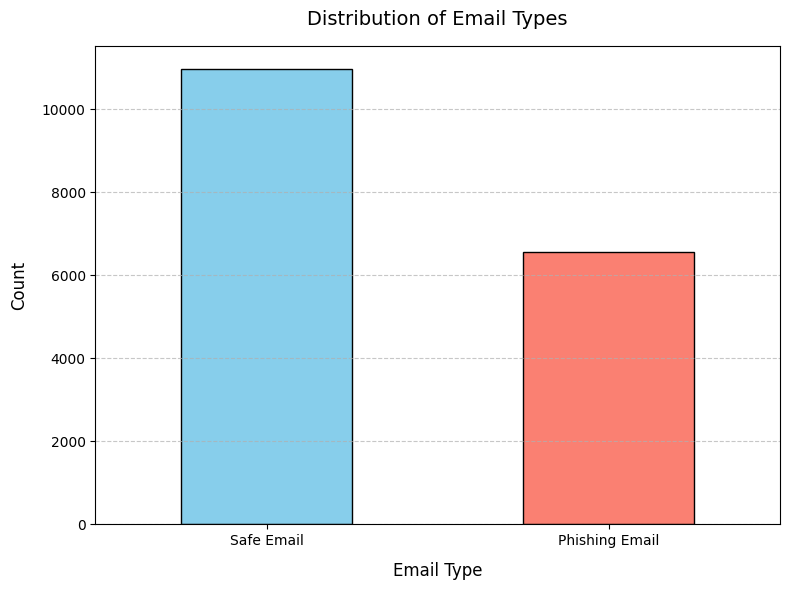

In [19]:
email_type_counts = df['Email Type'].value_counts()

# Assuming email_type_counts is already defined
colors = ['skyblue', 'salmon', 'limegreen', 'gold', 'purple']
plt.figure(figsize=(8, 6))
email_type_counts.plot(kind='bar', color=colors[:len(email_type_counts)], edgecolor='black')

# Adding labels and titles with proper alignment
plt.title('Distribution of Email Types', fontsize=14, pad=15)
plt.xlabel('Email Type', fontsize=12, labelpad=10)
plt.ylabel('Count', fontsize=12, labelpad=10)
plt.xticks(rotation=0, fontsize=10, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Class Encoding

In [20]:
le = LabelEncoder()

df["Email Type"] = le.fit_transform(df["Email Type"])

df.head()

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,1
1,the other side of galicismos galicismo is a sp...,1
2,re equistar deal tickets are you still availab...,1
3,hello i am your hot lil horny toy i am the one...,0
4,software at incredibly low prices 86 lower dra...,0


## Converting text into vector

In [21]:
vectorizer = CountVectorizer(binary=True, max_features=10000)
# The binary=True parameter in CountVectorizer transforms the output of the vectorizer into a binary representation. 
# This means that instead of counting the number of times a word appears in a document, the vectorizer will only indicate whether the word is present or not.
#vectorizer = TfidfVectorizer(stop_words="english",max_features=10000)

x = df["Email Text"]
y = df['Email Type']

x_vec = vectorizer.fit_transform(x).toarray()
y_vec = np.array(y)

## Cross-validation

In [22]:
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(x_vec,y_vec,test_size=0.2,random_state=42, stratify=y_vec)

X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Training Models

## Logistic Regression

In [23]:
lg = LogisticRegression(max_iter=500)
lg.fit(X_train_vec,y_train_vec)

LogisticRegression(max_iter=500)

In [57]:
# prediction
pred_lg = lg.predict(X_test_vec)

# performance
print("")
print(f"accuracy from logistic regression:{accuracy_score(y_test_vec,pred_lg)*100:.2f} %")
print(f"f1 score from logistic regression: {f1_score(y_test_vec,pred_lg)*100:.2f} %")
print("\nclassification report : \n",classification_report(y_test_vec,pred_lg,target_names=le.classes_))


accuracy from logistic regression:97.72 %
f1 score from logistic regression: 98.18 %

classification report : 
                 precision    recall  f1-score   support

Phishing Email       0.97      0.97      0.97      1312
    Safe Email       0.98      0.98      0.98      2196

      accuracy                           0.98      3508
     macro avg       0.98      0.98      0.98      3508
  weighted avg       0.98      0.98      0.98      3508



## Bert

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = os.cpu_count()
print(device)

cuda


In [27]:
# Load BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)

# Tokenizing the dataset
def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
class EmailDataset(Dataset):
    def __init__(self, texts, labels):
        self.data = []
        for text, label in tqdm(zip(texts, labels), total=len(texts), desc="Processing Dataset"):
            tokenized_input = tokenize_function(text)
            input_ids = tokenized_input['input_ids'].squeeze(0).to(device)
            attention_mask = tokenized_input['attention_mask'].squeeze(0).to(device)
            label_tensor = torch.tensor(label, dtype=torch.long).to(device)
            self.data.append({'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label_tensor})
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [51]:
train_dataset = EmailDataset(X_train_trans.tolist(), y_train_trans.tolist())
test_dataset = EmailDataset(X_test_trans.tolist(), y_test_trans.tolist())

Processing Dataset: 100%|██████████| 3508/3508 [00:23<00:00, 151.66it/s]


In [54]:
BATCH_SIZE = 16
STEPS = max((len(train_dataset) // BATCH_SIZE) // 4, 1)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    eval_strategy='steps',
    save_strategy='steps',
    logging_steps=STEPS,
    save_steps=STEPS,
    report_to='none',
    
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=1,
    weight_decay=0.01,
    
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,
)

In [55]:
trainer.train()

Step,Training Loss,Validation Loss
219,0.092800,0.114539
438,0.090900,0.094431
657,0.065900,0.059348
876,0.048800,0.053458


TrainOutput(global_step=877, training_loss=0.07451217514448168, metrics={'train_runtime': 996.1328, 'train_samples_per_second': 14.084, 'train_steps_per_second': 0.88, 'total_flos': 3691448106700800.0, 'train_loss': 0.07451217514448168, 'epoch': 1.0})

# Evaluation

In [56]:
# Define DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Evaluation loop
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Get predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            # Append predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Call the evaluation function
predictions, true_labels = evaluate_model(model, test_loader)

# Generate the classification report
report = classification_report(true_labels, predictions, target_names=le.classes_)
print(report)

                precision    recall  f1-score   support

Phishing Email       0.99      0.98      0.98      1312
    Safe Email       0.99      0.99      0.99      2196

      accuracy                           0.99      3508
     macro avg       0.99      0.98      0.99      3508
  weighted avg       0.99      0.99      0.99      3508

